 Neural Network Classification

Classification is a problem of predicting whether something is one thing or another and there can be multiple things such as option.

In [118]:
# Lets gather some data , first we need to import some modules
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split


In [119]:
# Data gather time
n_samples = 10000
x,y = make_circles(n_samples,noise=0.02,random_state=42)

# let's change our model from numpy array to tensor
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# lets represent data in pandas
circles = pd.DataFrame({"x1":x[:,0],"x2":x[:,1],"label":y})
circles.head(5)


,x1,x2,label
0,0.030309,0.816518,1.0
1,0.977438,-0.417815,0.0
2,-0.578424,0.803959,0.0
3,0.972489,-0.322973,0.0
4,0.828035,-0.553560,0.0


In [120]:
circles.label.value_counts()

,count
label,
1.0,5000
0.0,5000


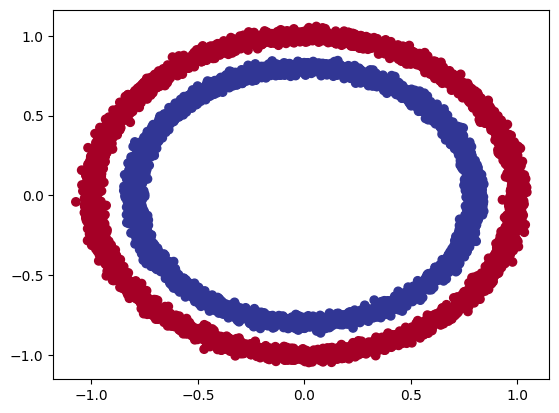

In [121]:
# lets visualize data with matplotlib
plt.scatter(x = x[:,0],
            y = x[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [122]:
# let's build a model
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.net  = nn.Sequential(
        nn.Linear(2,8),
        nn.ReLU(),
        nn.Linear(8,1)
    )
  def forward(self,x):
    return self.net(x)

model_0 = CircleModel()
model_0


CircleModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

### Things to know:
1) Weights decide how the point is looked at,
2) biases decide when neurons activate,
3) inference just tests current guesses, and
4) training reshapes those guesses until inside/outside becomes correct.

In [123]:
model_0.eval()
with torch.inference_mode():
  y_pred = model_0(x_test)
y_pred

# teh output should be like 0 or 1 but sicne it is vague and not good so i wille be

tensor([[-0.0446],
        [ 0.1437],
        [-0.2590],
        ...,
        [-0.2825],
        [ 0.1151],
        [ 0.1564]])

In [124]:
# Setup loss function and Optimizer
# Which loss function and Optimizer should I use , like for
# Regression I used the nn.L1Loss that was MAE (mean absolute error)
# or mean Squared Error ( )


### Setup Loss Function and Optimizer
They are actually case specific and for eg . I use the MAE (mean absolute error {there was another called MSE(Mean Squared Error as well}  for the Regression Model , I built but looks like I need a different one this time.)

Looking at the pyTorch documentation , I realized that the Binary cross entropy or categorical cross entropy (cross Entropy) is used for the classification model.

Reminder: Loss function measures how *wrong* our prediction is.

And for the optimizer, two of the most common and useful are SGD and Adam , however PyTorch has many built-in Options.
* For the loss function we are going to use `torch.nn.BCEWithLogitsLoss()`
-> since it automatically applies sigmoid.

Q) Why not BCE + separate sigmoid?
-> Works fine, but numerically unstable for large logits,
Can cause overflow / underflow.


 BCEWithLogitsLoss = sigmoid + BCE in one stable step → faster, safer, and more accurate for binary classification.



In [125]:
# Setup the loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
# Not using BCELoss directly since requires input to have gone through the sigmoid activation functon prior to input to BCELoss
optimizer = torch.optim.Adam(model_0.parameters(),lr=0.01)

In [126]:
model_0.state_dict()

OrderedDict([('net.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('net.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('net.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]])),
             ('net.2.bias', tensor([0.2730]))])

In [127]:
# CALCULATE THE ACCURACY - out of 100 examples , what percentage does our model get right
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc


### Training a model
'''

 training loop : for epoch in range -> we do the forward pass-> calculate the loss-> optimize the zero grad -> loss backward( Back propagation) -> optimize the step step step (Gradient descent)
 testing loop : model.eval do the forward pass loss bakcward see it go down down down

'''

### Going from raw logits -> prediction probabilities -> prediction labels

1) Our model outputs are going to be raw ***logits***.
We can convert this **logits** into prediction probabilities by passing them into some kind of activation functions. (e.g Sigmoid for binary classification and softmax for multiclass Classification.)

2) Then we can convert the model's prediction probabilities to **prediction labels **
 either by rounding them  -> binary classification
@ or taking the **argmax()** -> multiclass Classification

In [128]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test)[:5]
y_logits
# this is logit

tensor([[-0.0446],
        [ 0.1437],
        [-0.2590],
        [-0.3504],
        [-0.1973]])

In [129]:
# now we need to do output activation using activation function sigmoid for binary and softmax for multiclass
y_pred_probability = torch.sigmoid(y_logits)
y_pred_probability


tensor([[0.4888],
        [0.5359],
        [0.4356],
        [0.4133],
        [0.4508]])

### In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

1) If y_pred_probs >= 0.5, y=1 (class 1)
2) If y_pred_probs < 0.5, y=0 (class 0)''

In [130]:
y_pred_label = torch.round(y_pred_probability)
y_pred_label.squeeze() # we need to remove the column dimension we a


tensor([0., 1., 0., 0., 0.])

In [131]:
# since we got the same as our y_label now we are good to start building our training loop and testing loop
torch.manual_seed(42)
epochs = 1000

# Training loop

for epoch in range(epochs):
  model_0.train()
  # We do the forward pass
  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

# Testing loop
  model_0.eval()
  with torch.inference_mode():
  # Forward pass
    y_logits = model_0(x_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

  # loss /acc
  # since we use BCEwithLOgit loss it expect logits a input if we had have use BCEloss we would have passes sigmoid

    loss = loss_fn(y_logits,y_test)
    acc = accuracy_fn(y_true=y_test,y_pred=y_pred)


print(f"Loss: {loss} and Accuracy: {acc}")


Loss: 0.017404599115252495 and Accuracy: 100.0


In [132]:
# since it is really accurate and loss is also good loss is there since the probability isn't 100% same thats valid , now we got
# this data since we implemented the RELu rather than putting a lot of linear layer
# Adding ReLU between linear layers lets the model learn non-linear patterns, so accuracy can improve, whereas just stacking linear layers without ReLU is still effectively
# a single linear transformation, no matter how deep.

###4. Let's make predictions and evaluate the model
So to just inspect it lets visualize this.
To do so , we're going to import a function called `plot decision boundary()`


In [133]:
import requests
from pathlib import Path

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


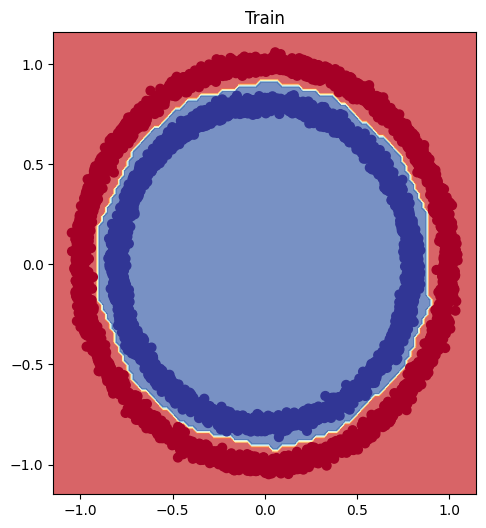

In [134]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)

###Using ReLU between linear layers:
 lets the model capture non-linear patterns, which improves accuracy, whereas stacking multiple linear layers without ReLU is effectively still a single linear transformation and gives vague predictions.

####Improving a model (from a model perspective)
* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation function
* changing the learning rate
* changing the loss function
* changing the optimizer

These all are from model's perspective because they deal directly with the model rather than the data itself , because these option are all values we (as machine learning engineer) can change hyperparameters.

We can try and improve our model by:
(do one at a time)
* Adding more hidden unit: 5-> 10
* Increase the number of layer: 2-> 3
* Increase the number of epochs: 100-> 1000



In [135]:
# after evaluating our model we do improve through experimentation
# torch.utils.tensorboard (we will do it later)



### In this data : Missing Piece = Non-Linearity
One thing to realize is if you were given an infinite amount of a straight line and non_straight line what patterns can you draw ?"

In [136]:
# Replicating non_linear functions

In [137]:
# toy tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

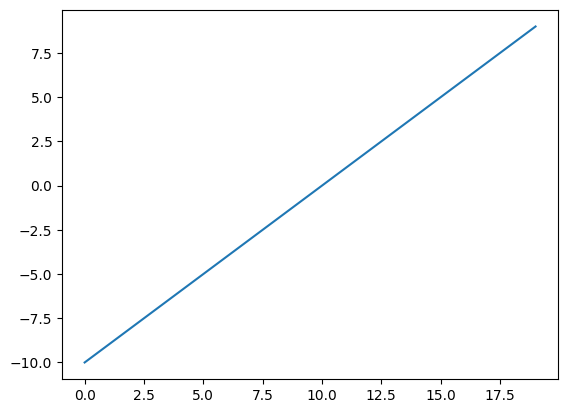

In [138]:
 # Visualize the toy tensor
plt.plot(A);

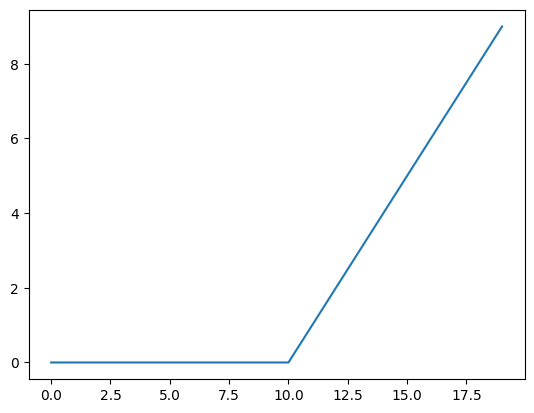

In [139]:
# create ReLU function by hand
def relu(X):
  return torch.maximum(torch.tensor(0),X)
relu(A)
plt.plot(relu(A))
# just as expected

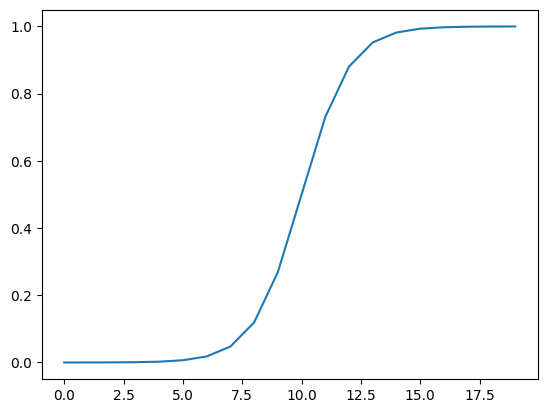

In [140]:
# Now let's plot the sigmoid function
def sigmoid(x):
  return 1/(1+torch.exp(-x))
sigmoid(A)
plt.plot(sigmoid(A))
# yeppp

### 8 . Putting all together with a multiclass classification function
Binary classification predicts one of two options (e.g., cat vs. dog), while multi-class classification predicts one of several options (e.g., cat, dog, or chicken)

In [141]:
#1) Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
import pandas as pd

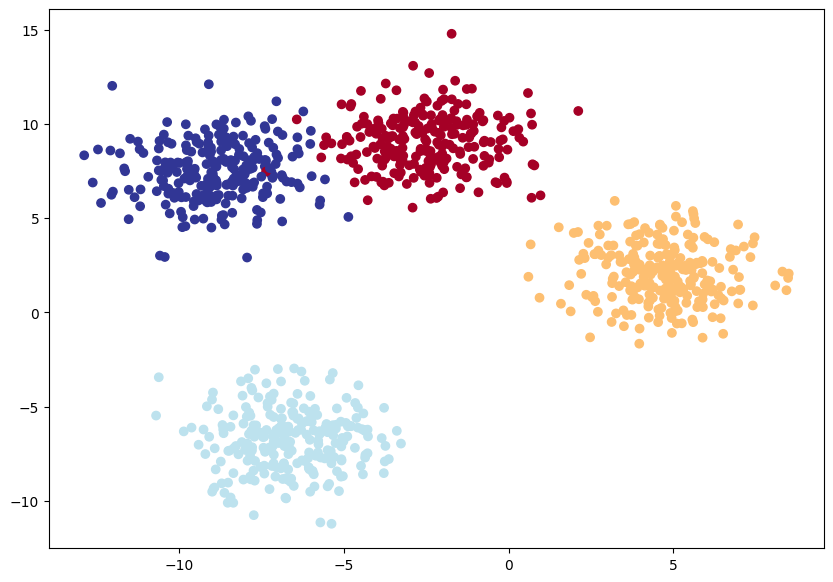

In [155]:
# Let's make data ready
''' sklearn.datasets.make_blobs(n_samples=100, n_features=2,
 *, centers=None, cluster_std=1.0,
  center_box=(-10.0, 10.0), shuffle=True,
   random_state=None, return_centers=False) '''
# set hyperparamaters ( we usually uppercase them)
NUM_CLASSES = 4
NUM_FEATURES = 2
NUM_SAMPLES = 1000

# create multiclass data
x_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # to add randomness
                            random_state=42)
# turning data into tensor
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
x_blob[:5],y_blob[:5]

# splitting data into train and test
x_blob_train,x_blob_test,y_blob_train,y_blob_test = train_test_split(x_blob,y_blob,test_size=0.2,
                                                                     random_state=42)

# plot data(visualize , visualize , visualize)
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class Classification Model

In [159]:
from torch import nn


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [160]:
x_blob_train[:5],

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]])

In [161]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [163]:
model_4(x_blob_train)[:5]
# this is to run a single forward pass with our model

tensor([[ 0.2562,  0.3353, -0.1443, -0.3059],
        [ 0.1043, -0.1746,  0.1808, -0.1935],
        [-0.5386,  0.2705,  0.1246, -1.1905],
        [-0.1889,  0.0807,  0.1564, -0.7154],
        [ 0.1061, -0.1702,  0.1799, -0.1935]], grad_fn=<SliceBackward0>)

In [167]:
y_logits = model_4(x_blob_test)

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950]], grad_fn=<SliceBackward0>)
tensor([[0.2979, 0.3062, 0.2190, 0.1769],
        [0.2092, 0.2272, 0.3971, 0.1666],
        [0.1989, 0.3577, 0.3329, 0.1105],
        [0.3012, 0.3272, 0.2004, 0.1712],
        [0.2832, 0.2280, 0.2874, 0.2014]], grad_fn=<SliceBackward0>)


In [174]:
torch.manual_seed(42)


epochs = 100


for epoch in range(epochs):
    y_blob_train = y_blob_train.type(torch.LongTensor)
    y_blob_test = y_blob_test.type(torch.LongTensor)
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(x_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(x_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.32603, Acc: 33.00% | Test Loss: 1.16789, Test Acc: 50.50%
Epoch: 10 | Loss: 0.56130, Acc: 77.50% | Test Loss: 0.51789, Test Acc: 76.50%
Epoch: 20 | Loss: 0.37431, Acc: 81.12% | Test Loss: 0.36443, Test Acc: 82.00%
Epoch: 30 | Loss: 0.27698, Acc: 94.00% | Test Loss: 0.25921, Test Acc: 97.50%
Epoch: 40 | Loss: 0.14797, Acc: 98.62% | Test Loss: 0.13505, Test Acc: 100.00%
Epoch: 50 | Loss: 0.09577, Acc: 99.00% | Test Loss: 0.08503, Test Acc: 99.50%
Epoch: 60 | Loss: 0.07167, Acc: 99.00% | Test Loss: 0.06172, Test Acc: 99.50%
Epoch: 70 | Loss: 0.05855, Acc: 99.12% | Test Loss: 0.04892, Test Acc: 99.50%
Epoch: 80 | Loss: 0.05049, Acc: 99.12% | Test Loss: 0.04102, Test Acc: 99.50%
Epoch: 90 | Loss: 0.04512, Acc: 99.12% | Test Loss: 0.03573, Test Acc: 99.50%


In [175]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_blob_test)


y_logits[:10]

tensor([[  3.5173,   9.1493,  -4.4478, -10.7253],
        [  3.3038, -11.2972,  -4.7749,   7.6802],
        [ -3.0950,  -0.9639,   6.5657,  -4.0219],
        [  2.1983,   5.5324,  -2.5983,  -6.4732],
        [  4.9600,   0.7375,  -6.8889,  -4.3687],
        [  3.7785, -13.4964,  -5.5557,   9.2136],
        [ -2.8146,  -0.5542,   6.2770,  -4.3717],
        [  4.3997,  -2.4249,  -6.1456,  -1.0955],
        [ -3.2904,  -3.3460,   6.6489,  -2.7213],
        [  4.5264,  -1.2334,  -6.2985,  -2.2611]])

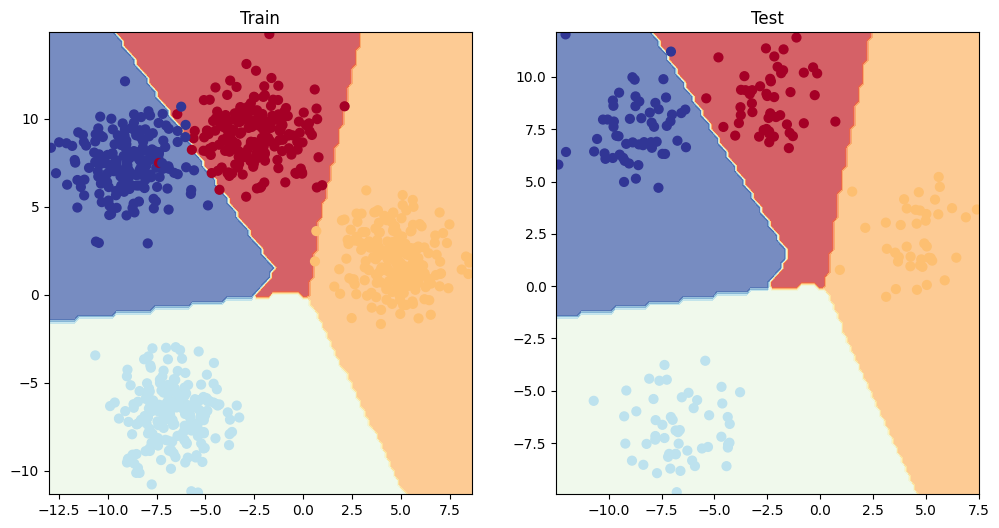

In [177]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)